## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from tqdm.notebook import tqdm
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

import shap

# Load the Dataset

In [2]:
df = pd.read_csv('./train.csv', index_col='Id').drop(columns=['Functional', 'LowQualFinSF'])
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


# 1) Exploratory Data Analysis

### Split the columns in *categorical*, *numeric* and *categorical numeric*

In [3]:
cat_col = [f for f in df.columns if df.dtypes[f] == 'object']
cat_num_col = ['MSSubClass', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'YrSold', 'MoSold',
               'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'OverallCond', 'OverallQual']
num_col = list(set(df).difference(cat_col + cat_num_col + ['SalePrice']))

## Pair Plots - Relates *features* and *Sale Price*
### Numeric variables

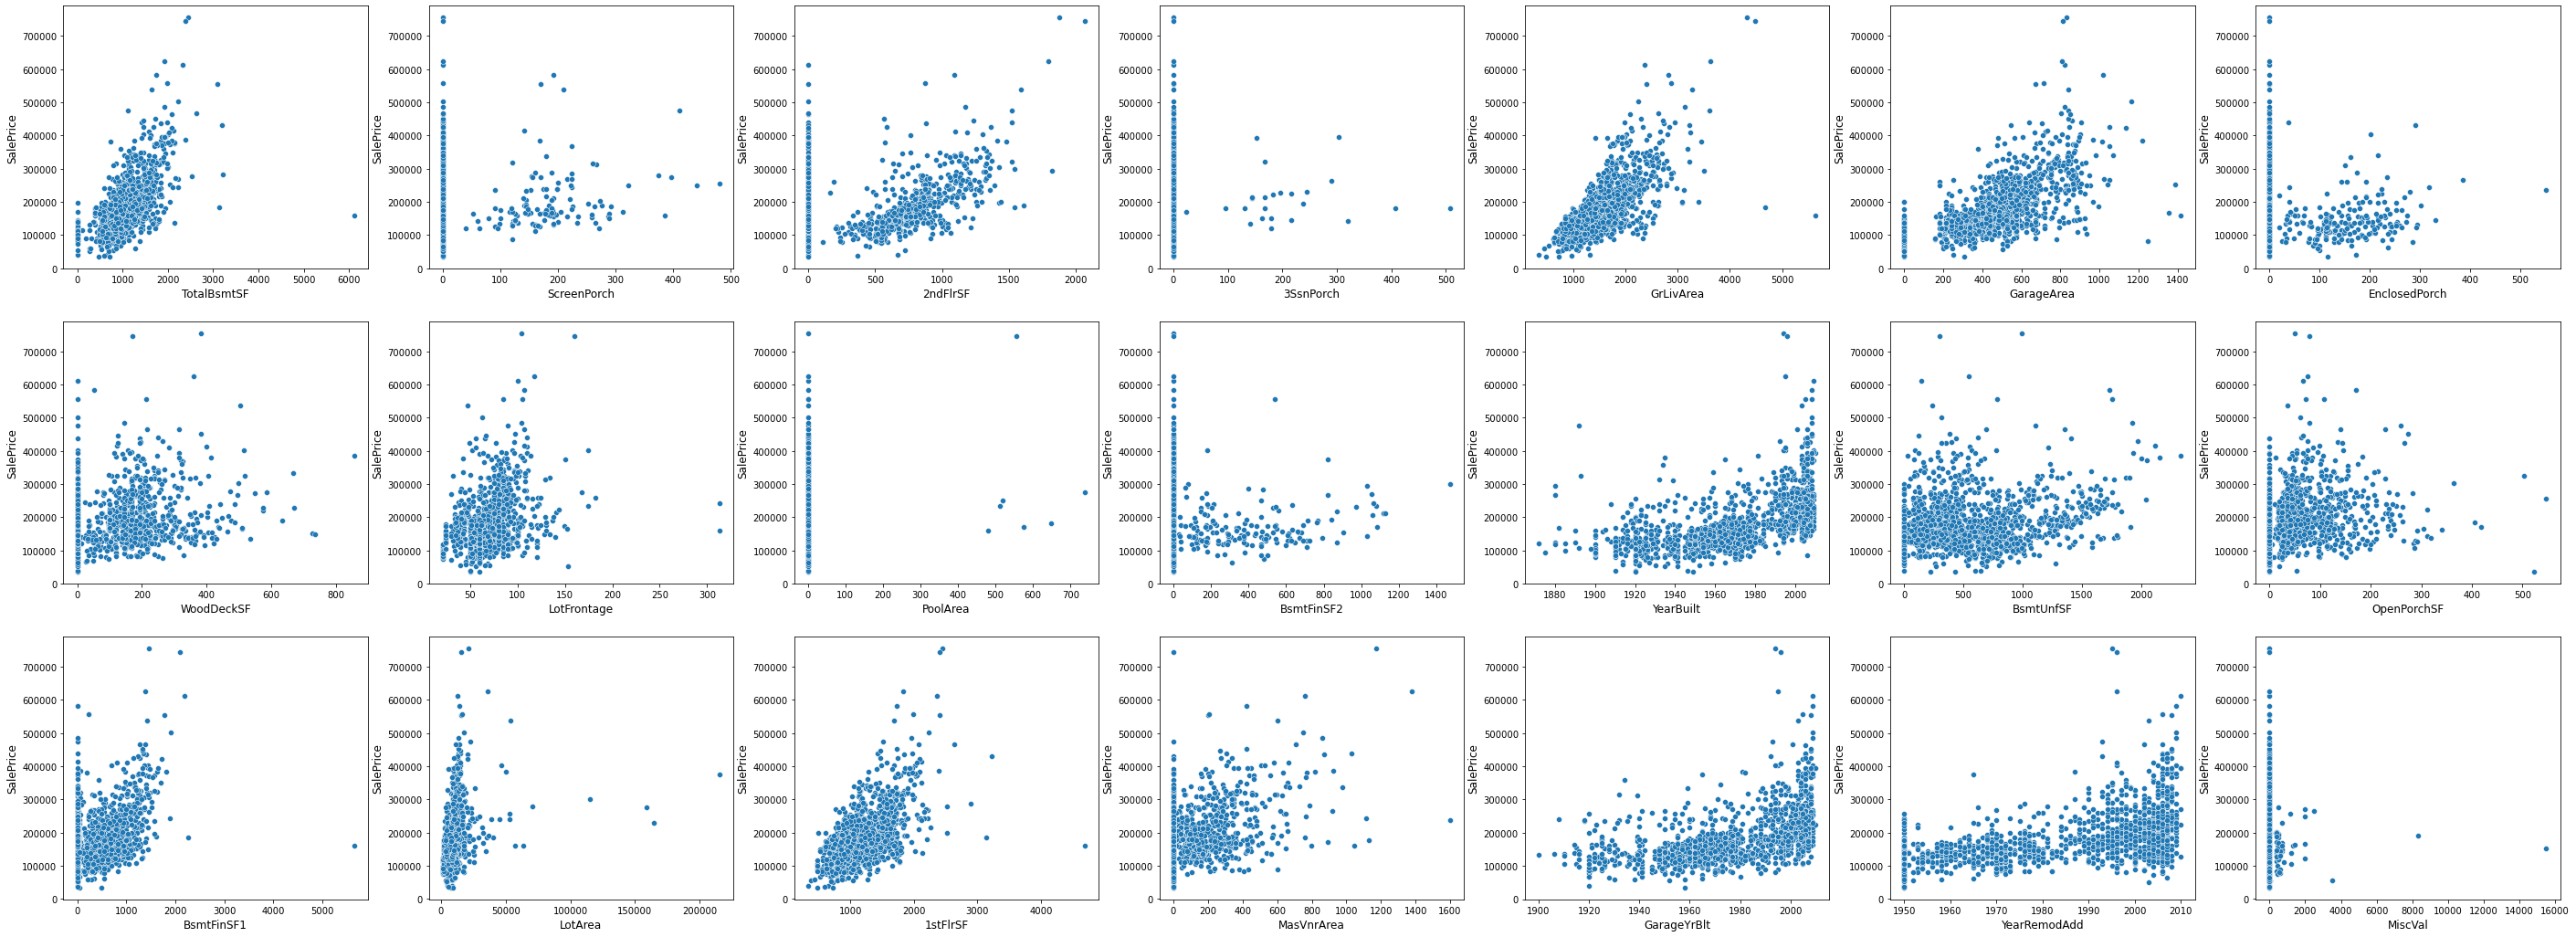

In [4]:
fig, axs = plt.subplots(3, 7, figsize=(49, 18))
for col, ax in zip(num_col, axs.flatten()):
    sns.scatterplot(x=df[col], y=df['SalePrice'], ax=ax)
    ax.yaxis.label.set_size('large')
    ax.xaxis.label.set_size('large')

*   ```YearBuilt```: *Original construction date*. This feature shows an interesting growth in the last period since a recent house is valued more on the market.

*   ```1ndFlrSF``` and ```2stFlrSF```: *First Floor square feet* and *Second floor square feet*. These show the correlation between price and the 1st and 2nd floor sizes.

*  ```GarageArea```: *Size of garage in square feet*. It shows the exact same trend that is featured on the floors squared feet: a larger garage area leads to an higher sale price. 

#### Plot for the Report

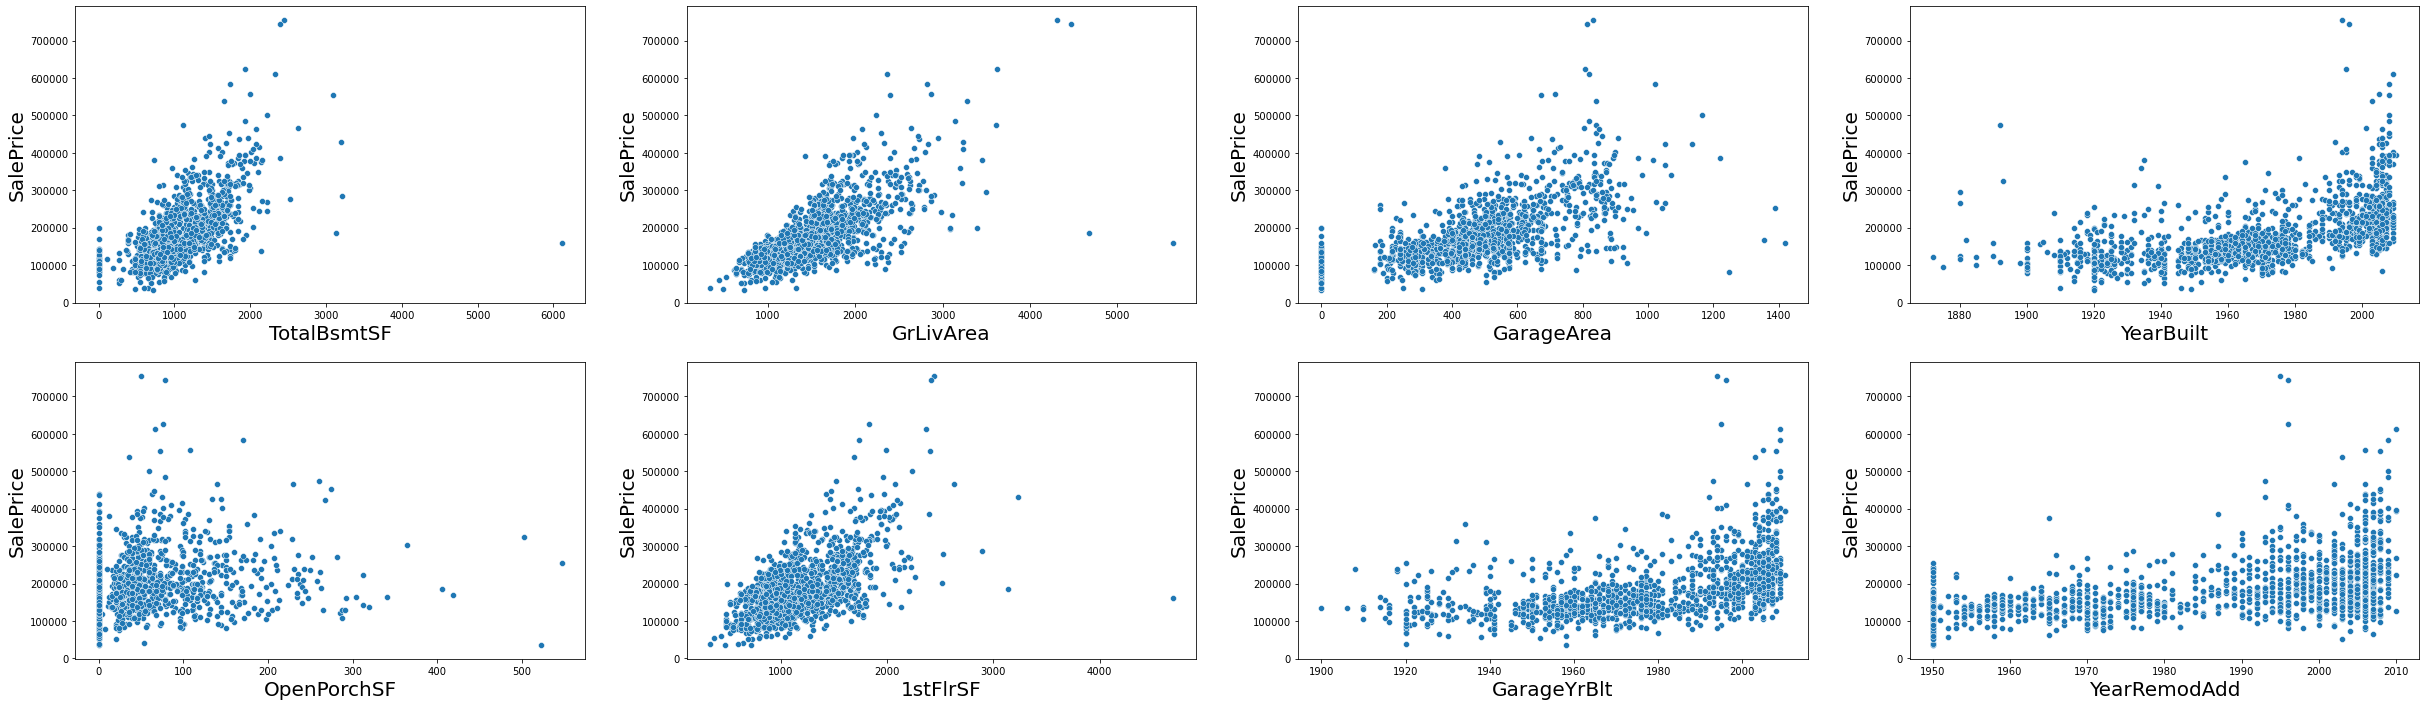

In [5]:
plot_df = df[num_col].loc[:,df[num_col + ['SalePrice']].corr(method='spearman')['SalePrice'].drop('SalePrice') > .46]
fig, axs = plt.subplots(2, 4, figsize=(42, 12))
for col, ax in zip(plot_df.columns, axs.flatten()):
    sns.scatterplot(x=df[col], y=df['SalePrice'], ax=ax)
    ax.yaxis.label.set_size(20)
    ax.xaxis.label.set_size(20)
plt.savefig('num_feats.pdf', bbox_inches='tight')

### Categorical variables

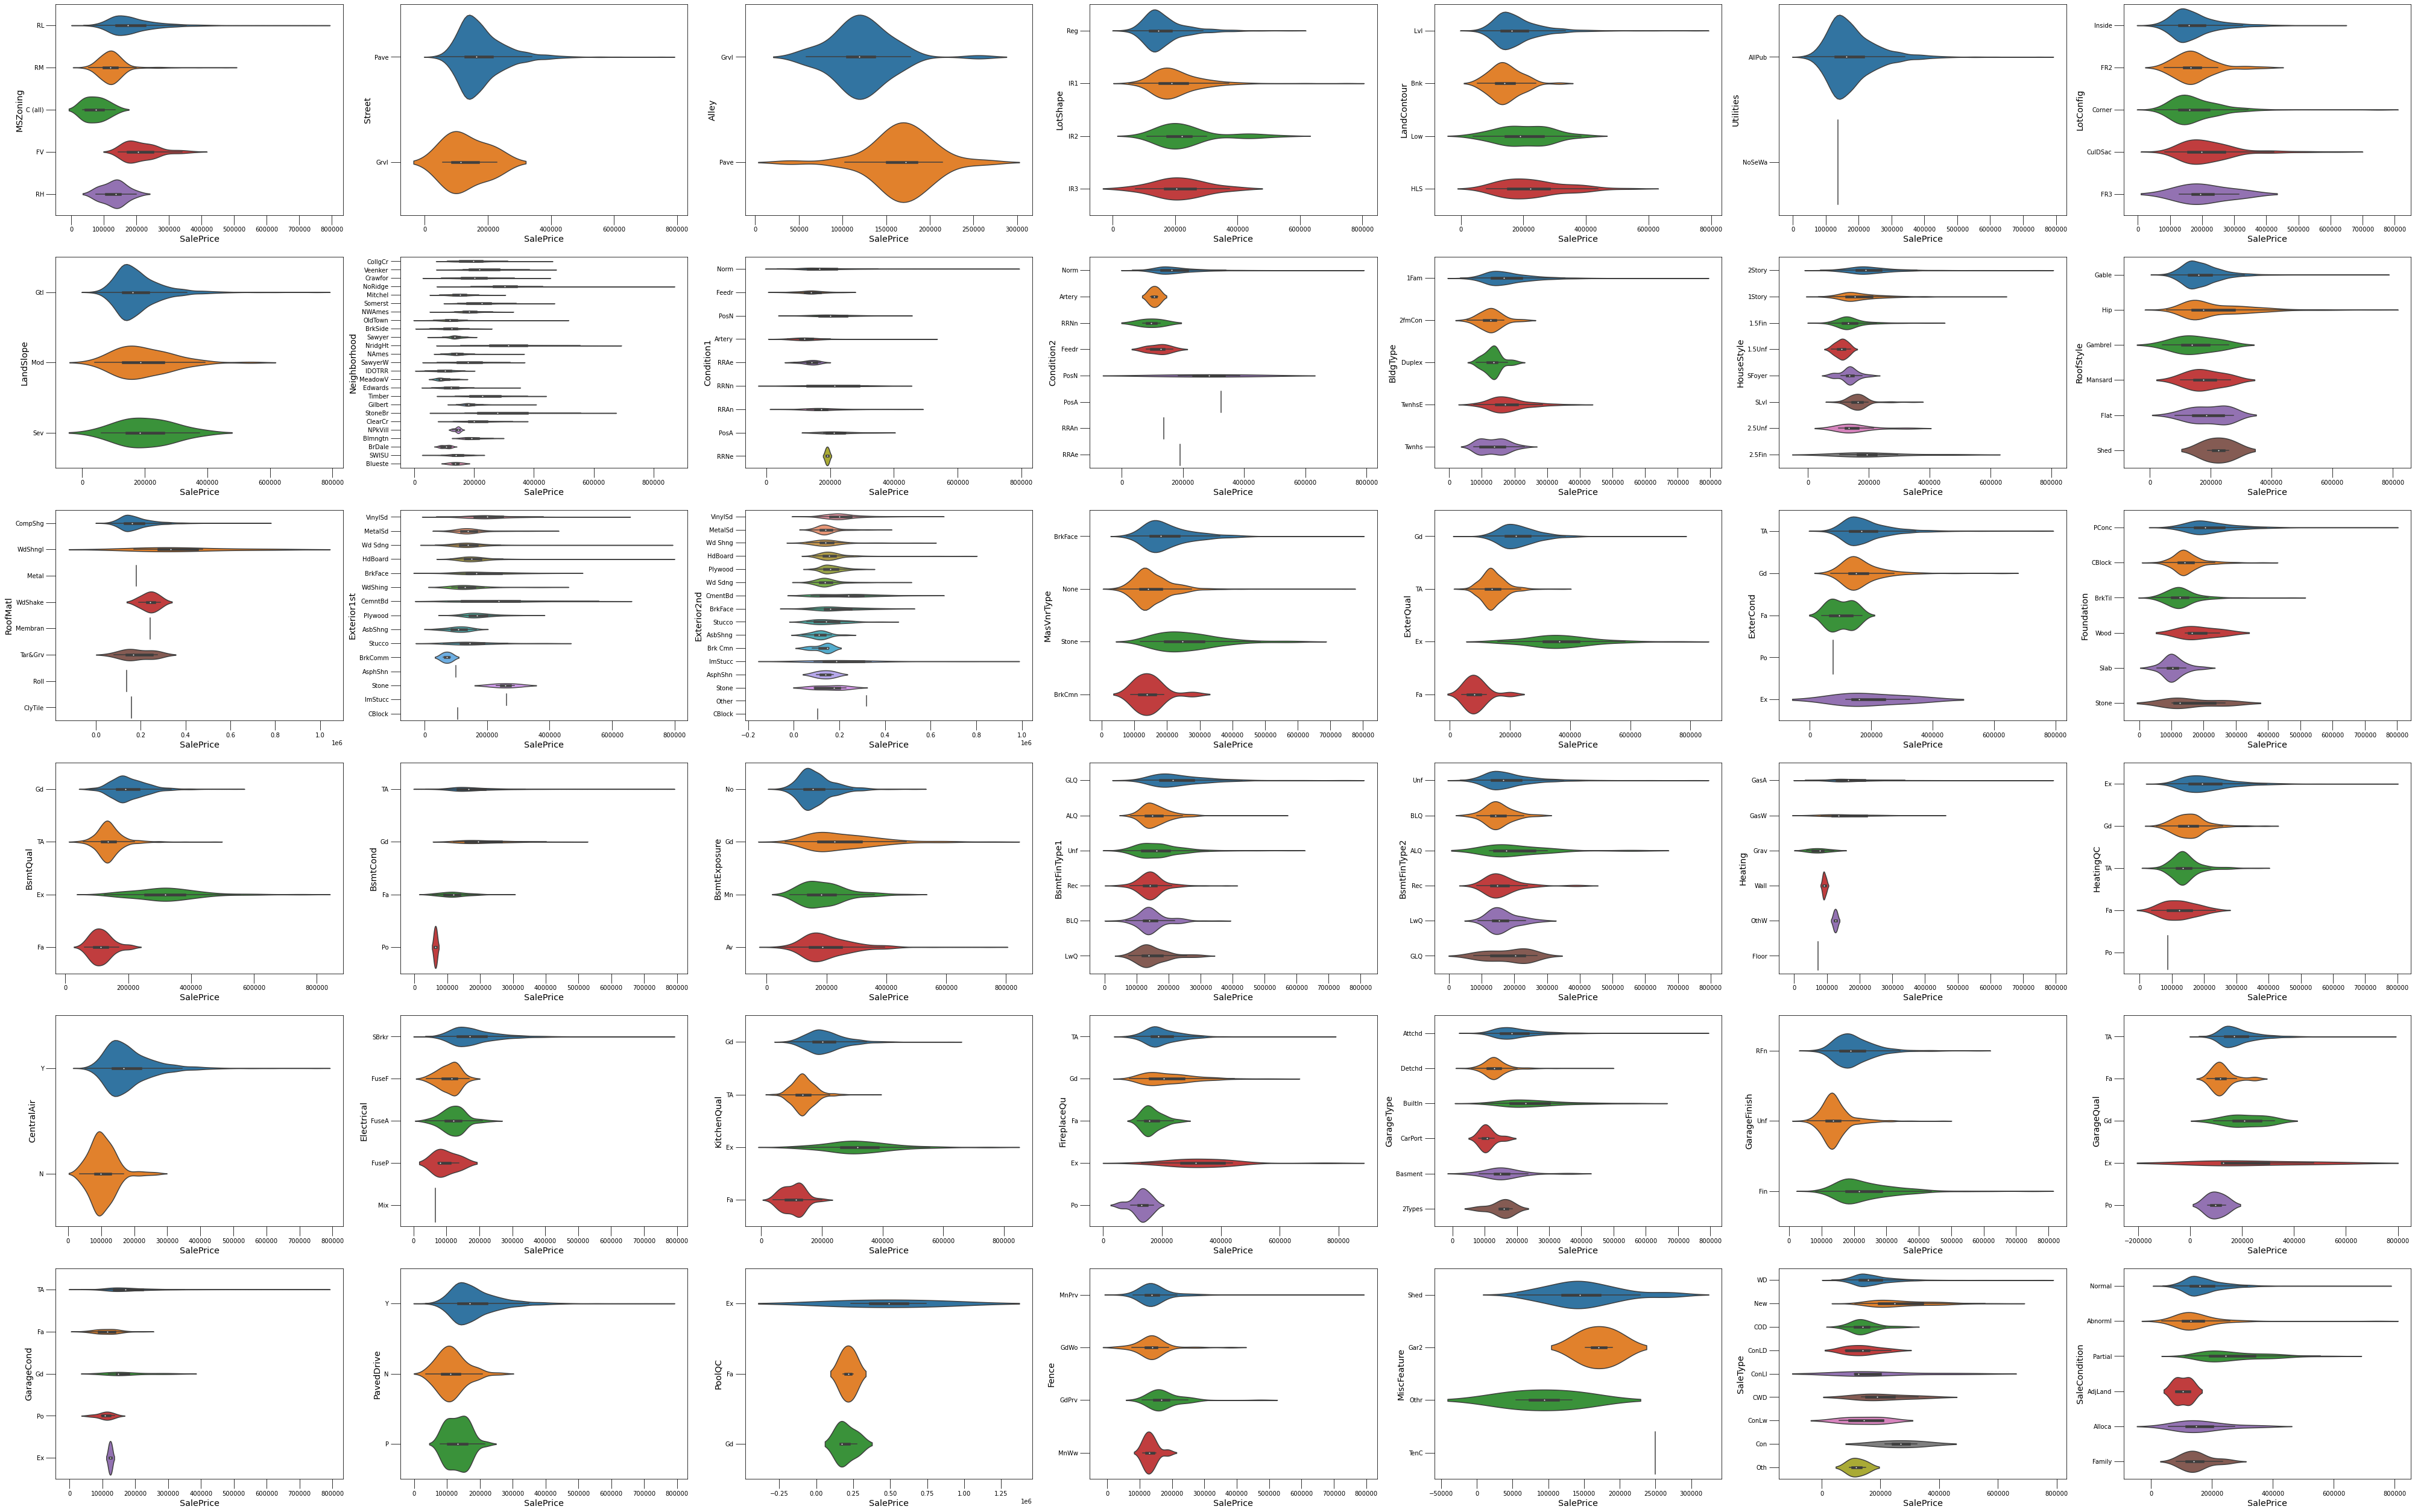

In [6]:
fig, axs = plt.subplots(6, 7, figsize=(70, 45))
for col, ax in zip(cat_col, axs.flatten()):
    sns.violinplot(y=df[col], x=df['SalePrice'], orient="h", ax=ax)
    ax.yaxis.label.set_size('x-large')
    ax.xaxis.label.set_size('x-large')
    ax.tick_params(axis='both', size=16)

*   ```Neighborhood```: *Physical locations within Ames city limits*. A very interesting plot showing the price difference based off the neighborhood the house is built into

*   ```MasVnrType```: *Masonry veneer type*. It is a curious plot that shows how a stone (**Stone**) built house is much more appreciated then the other ones. 


*   ```PoolQC```: *Pool quality*. The pool quality is shown to be a very discriminant factor, an excellent (**Ex**) pool has a huge price spike


*   ```BsmntQual```: *Evaluates the height of the basement*. Following the same pattern as the pool a excellent (**Ex: 100+ inches**) basement greatly improves the house price.

### Categorical numeric variables

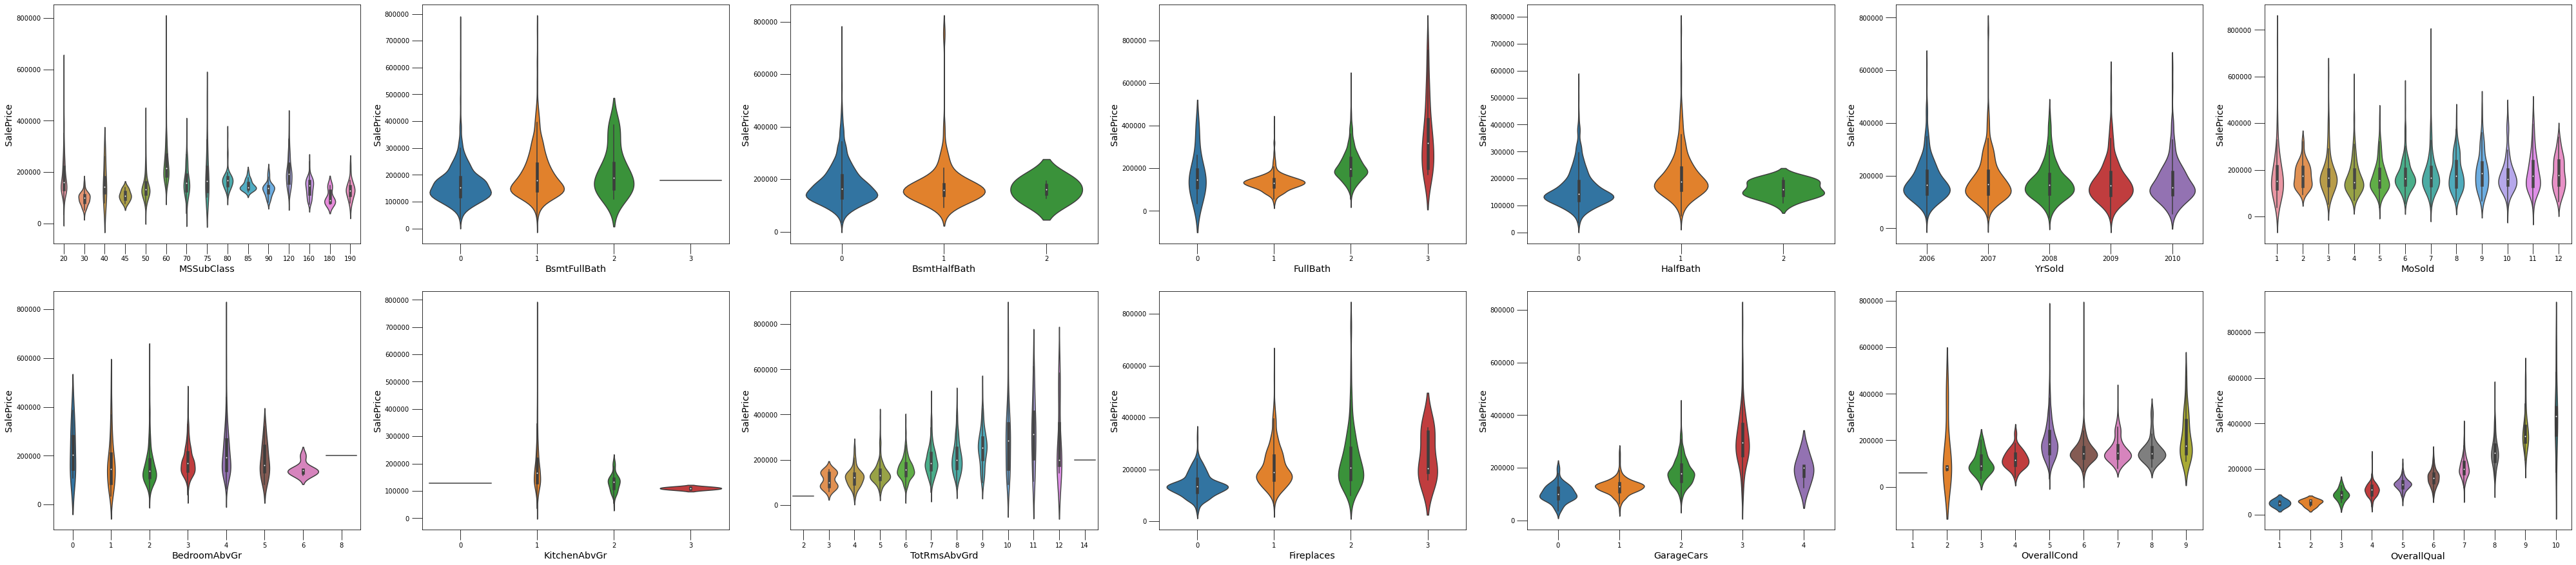

In [7]:
fig, axs = plt.subplots(2, 7, figsize=(70, 15))
for col, ax in zip(cat_num_col, axs.flatten()):
    sns.violinplot(x=df[col], y=df['SalePrice'], ax=ax)
    ax.yaxis.label.set_size('x-large')
    ax.xaxis.label.set_size('x-large')
    ax.tick_params(axis='both', size=16)

* ```OverallQual```: *Rates the overall material and finish of the house*. The overall quality is a very important feature to analyze and it correctly shows a growth of price as the condition scales.

*   ```FullBath```: *Full bathrooms above grade*. As expected the number of baths greatly contributes to the house final price as shown

*   ```TotRmsAbvGrd```: *Total rooms above grade (does not include bathrooms)*. The total number of rooms follows the same trend as the Squared Feet plot, as expected

#### Plot for the Report

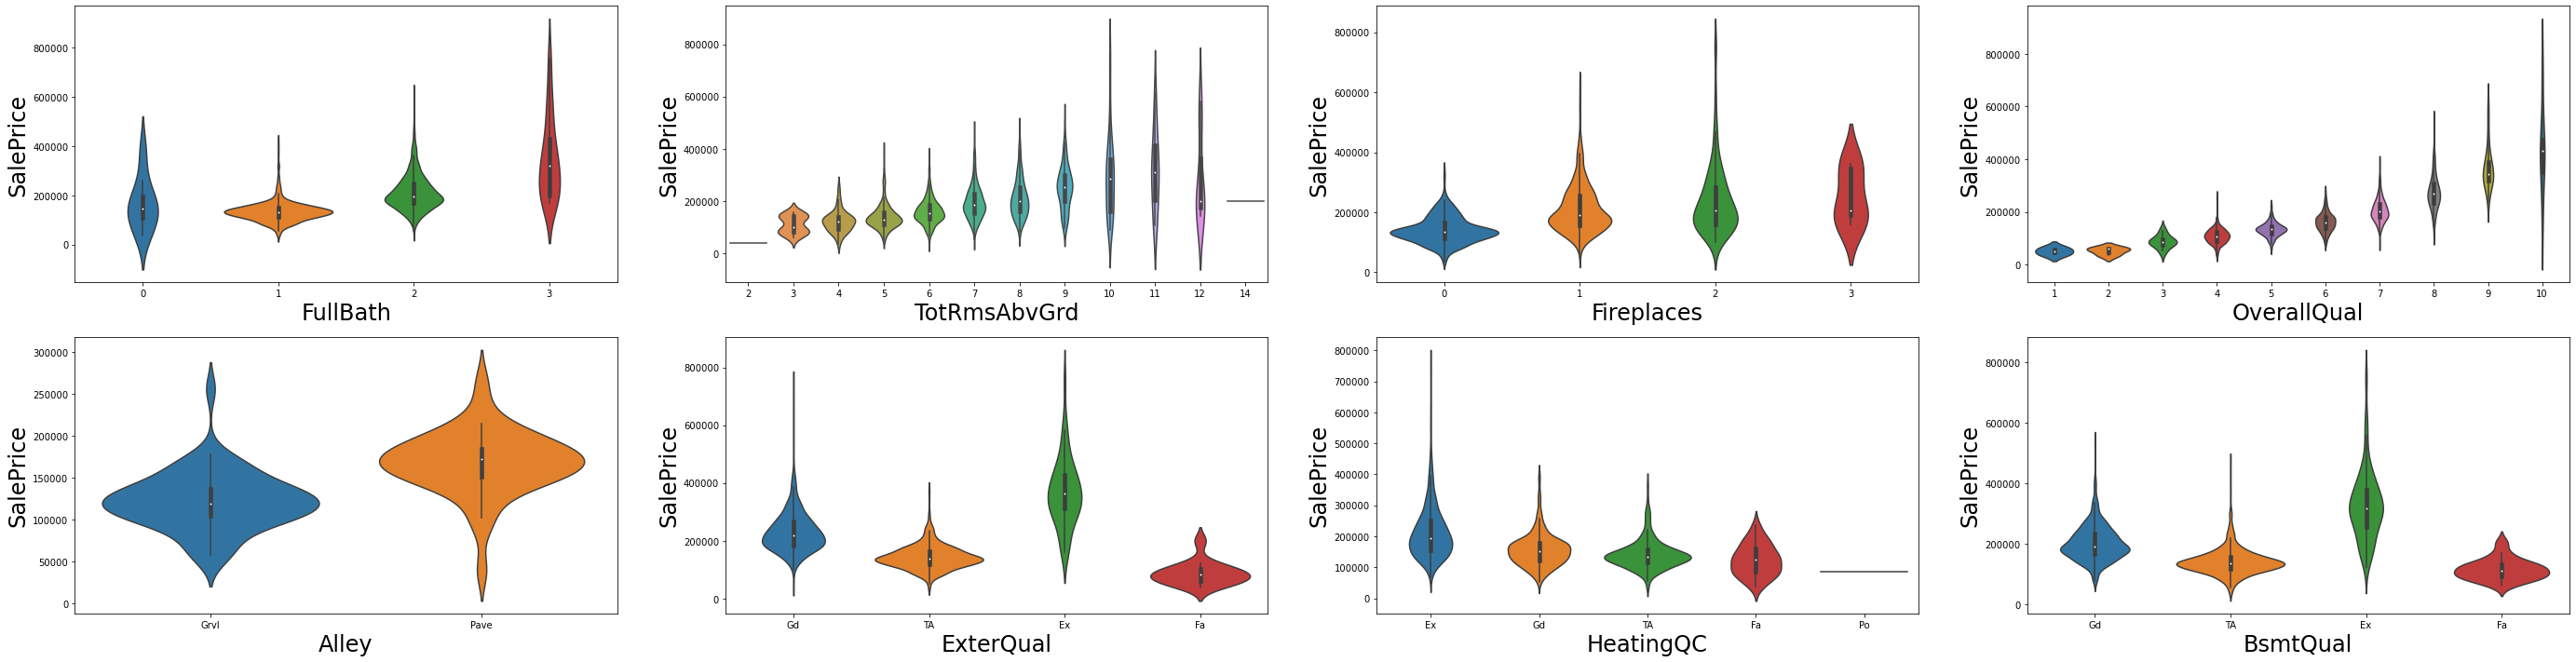

In [8]:
selected_num_cat_feats = ['FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'OverallQual']
selected_str_cat_feats = ['Alley', 'ExterQual', 'HeatingQC', 'BsmtQual', 'CentralAir']
selected_categorical_feats = selected_num_cat_feats + selected_str_cat_feats
plot_df = df[selected_categorical_feats]
fig, axs = plt.subplots(2, 4, figsize=(48, 12))
for col, ax in zip(selected_categorical_feats, axs.flatten()):
    sns.violinplot(x=df[col], y=df['SalePrice'], ax=ax)
    ax.yaxis.label.set_size(24)
    ax.xaxis.label.set_size(24)
    
plt.savefig('cat_feats.pdf', bbox_inches='tight')

### Main Features
Plot the most price dependent features found above. We used this plot in our second presentation therefore it is no longer useful.

In [9]:
# main_cat_feats = ['OverallQual', 'FullBath', 'TotRmsAbvGrd']
# main_num_feats = ['1stFlrSF', '2ndFlrSF', 'YearBuilt']
# n_main_num_feats = len(main_cat_feats)

# fig, axs = plt.subplots(3, 2, figsize=(20, 24))
# axs_l = axs.flatten()
# for i, (main_num_col, main_cat_col) in enumerate(zip(main_num_feats, main_cat_feats)):
#     i *= 2
#     sns.scatterplot(x=df[main_num_col], y=df['SalePrice'], ax=axs_l[i])
#     correlation = round(np.corrcoef(df[main_num_col], df['SalePrice'])[0,1], 2)
#     axs_l[i].set_title(f'Correlation: $\\rho = {correlation}$', fontsize=22)
#     axs_l[i].yaxis.label.set_size('x-large')
#     axs_l[i].xaxis.label.set_size('x-large')
#     axs_l[i].set_xlabel(main_num_col, fontsize=18)
#     axs_l[i].set_ylabel('Sale Price', fontsize=18)
#     axs_l[i].tick_params(axis='both', size=16)
    
#     sns.violinplot(x=df[main_cat_col], y=df['SalePrice'], ax=axs_l[i + 1])
#     correlation = round(np.corrcoef(df[main_cat_col], df['SalePrice'])[0,1], 2)
#     axs_l[i + 1].set_title(f'Correlation: $\\rho = {correlation}$', fontsize=22)
#     axs_l[i + 1].yaxis.label.set_size('x-large')
#     axs_l[i + 1].xaxis.label.set_size('x-large')
#     axs_l[i + 1].set_xlabel(main_cat_col, fontsize=18)
#     axs_l[i + 1].set_ylabel('Sale Price', fontsize=18)
#     axs_l[i + 1].tick_params(axis='both', size=16)
# plt.savefig('price_relation.jpg')
# plt.show()

## Tranform Categorical Variables
### One-Hot Vector

In [10]:
encoded_df = pd.DataFrame()
for col in cat_col:
    one_hot_df = pd.get_dummies(df[col], prefix=col)
    encoded_df = pd.concat([encoded_df, one_hot_df], axis=1)

### Create a transformed version of the Dataset

In [11]:
transf_df = pd.concat([df[num_col + cat_num_col], encoded_df, df[['SalePrice']]], axis=1)
transf_df

,TotalBsmtSF,ScreenPorch,2ndFlrSF,3SsnPorch,GrLivArea,GarageArea,EnclosedPorch,WoodDeckSF,LotFrontage,PoolArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,856,0,854,0,1710,548,0,0,65.0,0,...,0,0,1,0,0,0,0,1,0,208500
2,1262,0,0,0,1262,460,0,298,80.0,0,...,0,0,1,0,0,0,0,1,0,181500
3,920,0,866,0,1786,608,0,0,68.0,0,...,0,0,1,0,0,0,0,1,0,223500
4,756,0,756,0,1717,642,272,0,60.0,0,...,0,0,1,1,0,0,0,0,0,140000
5,1145,0,1053,0,2198,836,0,192,84.0,0,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,953,0,694,0,1647,460,0,0,62.0,0,...,0,0,1,0,0,0,0,1,0,175000
1457,1542,0,0,0,2073,500,0,349,85.0,0,...,0,0,1,0,0,0,0,1,0,210000
1458,1152,0,1152,0,2340,252,0,0,66.0,0,...,0,0,1,0,0,0,0,1,0,266500


## Correlations
### Spearman Correlations between *numeric variables* and the *price*

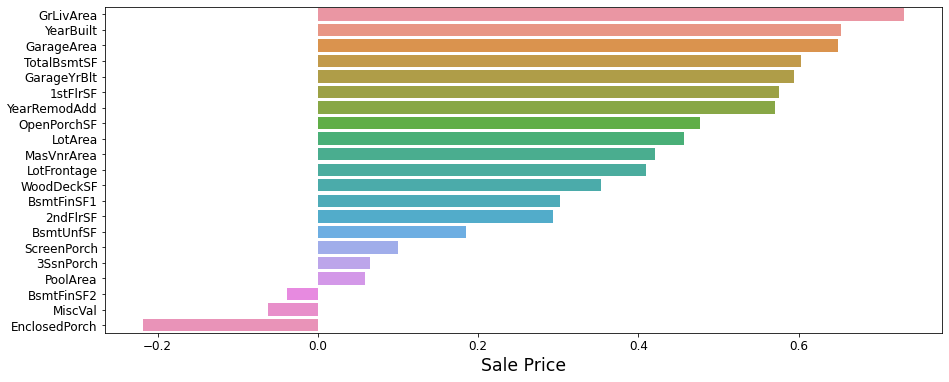

In [12]:
num_corr_df = df[num_col + ['SalePrice']].corr(method='spearman')['SalePrice'].drop('SalePrice').sort_values(ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(data=num_corr_df.reset_index(), y='index', x='SalePrice', orient='h')
plt.ylabel('')
plt.xlabel('Sale Price', fontsize='xx-large')
plt.tick_params(axis='both', labelsize=12)
plt.show()

### Spearman Correlations between *categorical numeric variables* and the *price*

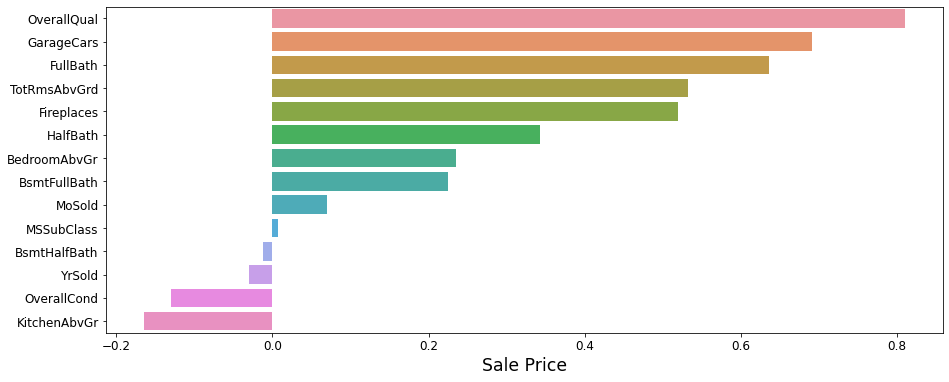

In [13]:
cat_num_corr_df = df[cat_num_col + ['SalePrice']].corr(method='spearman')['SalePrice'].drop('SalePrice').sort_values(ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(data=cat_num_corr_df.reset_index(), y='index', x='SalePrice', orient='h')
plt.ylabel('')
plt.xlabel('Sale Price', fontsize='xx-large')
plt.tick_params(axis='both', labelsize=12)
plt.show()

### Top 15 strongest Spearman Correlations between *one-hot encoded categorical variables* and the *price*

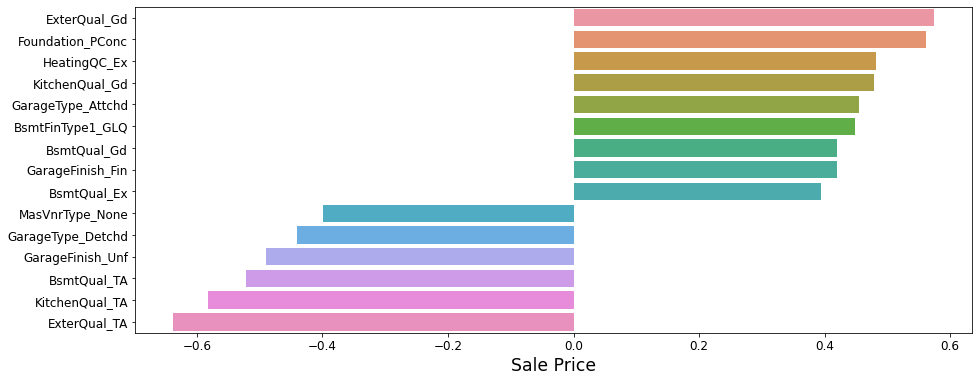

In [14]:
plt.figure(figsize=(15, 6))
cat_corr_df = transf_df.drop(columns=cat_num_col + num_col).corr(method='spearman')['SalePrice'].drop('SalePrice').reset_index()
cat_corr_df['magnitude'] = cat_corr_df['SalePrice'].abs()
n_coef = 15
coefs = cat_corr_df.sort_values('magnitude', ascending=False).iloc[:n_coef].sort_values('SalePrice', ascending=False)
sns.barplot(y=coefs['index'], x=coefs['SalePrice'], orient='h')
plt.ylabel('')
plt.xlabel('Sale Price', fontsize='xx-large')
plt.tick_params(axis='both', labelsize=12)
plt.show()

### Top 15 Spearman Correlations

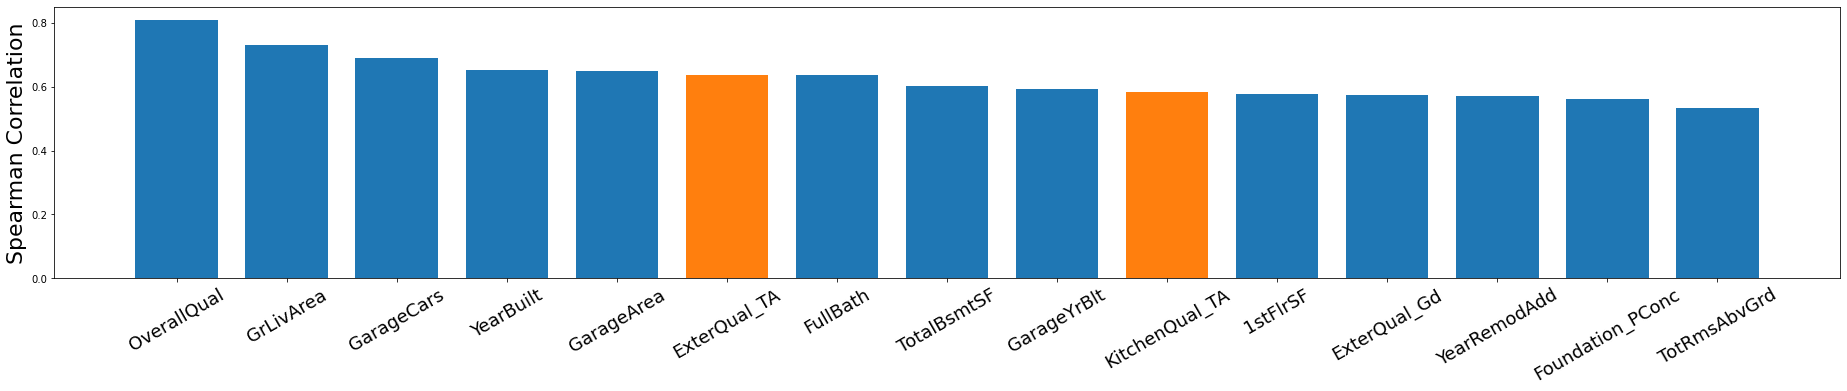

In [15]:
plt.figure(figsize=(32, 5))
n_bars = 15
price_corr_df = transf_df.corr(method='spearman')['SalePrice'].drop('SalePrice').reset_index()
price_corr_df['Magnitude'] = price_corr_df['SalePrice'].abs()
price_corr_df['sign'] = price_corr_df['SalePrice'] < 0
price_corr_df = price_corr_df.sort_values('Magnitude', ascending=False)
price_corr_df = price_corr_df.iloc[:n_bars]
plt.bar(x=price_corr_df['index'], height=price_corr_df['Magnitude'], 
        color=[sns.color_palette()[idx] for idx in price_corr_df['sign']],
        width=.75)
plt.tick_params(axis='x', labelsize=14)
plt.yticks(np.linspace(0, .8, 5))
plt.tick_params(axis='x', labelsize=18, rotation=30)
plt.ylabel('Spearman Correlation', fontsize=22)
plt.savefig('price_correlations.pdf', bbox_inches='tight')
plt.show()

# 2) Machine Learning
### Split in train and test and transform $Price$ in $log(Price)$

In [16]:
transf_df

,TotalBsmtSF,ScreenPorch,2ndFlrSF,3SsnPorch,GrLivArea,GarageArea,EnclosedPorch,WoodDeckSF,LotFrontage,PoolArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,856,0,854,0,1710,548,0,0,65.0,0,...,0,0,1,0,0,0,0,1,0,208500
2,1262,0,0,0,1262,460,0,298,80.0,0,...,0,0,1,0,0,0,0,1,0,181500
3,920,0,866,0,1786,608,0,0,68.0,0,...,0,0,1,0,0,0,0,1,0,223500
4,756,0,756,0,1717,642,272,0,60.0,0,...,0,0,1,1,0,0,0,0,0,140000
5,1145,0,1053,0,2198,836,0,192,84.0,0,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,953,0,694,0,1647,460,0,0,62.0,0,...,0,0,1,0,0,0,0,1,0,175000
1457,1542,0,0,0,2073,500,0,349,85.0,0,...,0,0,1,0,0,0,0,1,0,210000
1458,1152,0,1152,0,2340,252,0,0,66.0,0,...,0,0,1,0,0,0,0,1,0,266500


In [17]:
transf_df = transf_df.dropna()
X, y = transf_df.drop(columns='SalePrice'), np.log(transf_df['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=.75)

### Normalize the features

In [18]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Ridge Regression

In [19]:
lin_model = Ridge().fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)
print(f'RMSLE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin))}')
print(f'RMALE: {np.sqrt(metrics.mean_absolute_error(y_test, y_pred_lin))}')

RMSLE: 0.1965036581954548
RMALE: 0.3051706024166457


### Model Explaination
Plot for each feature the relative multiplicative coefficient

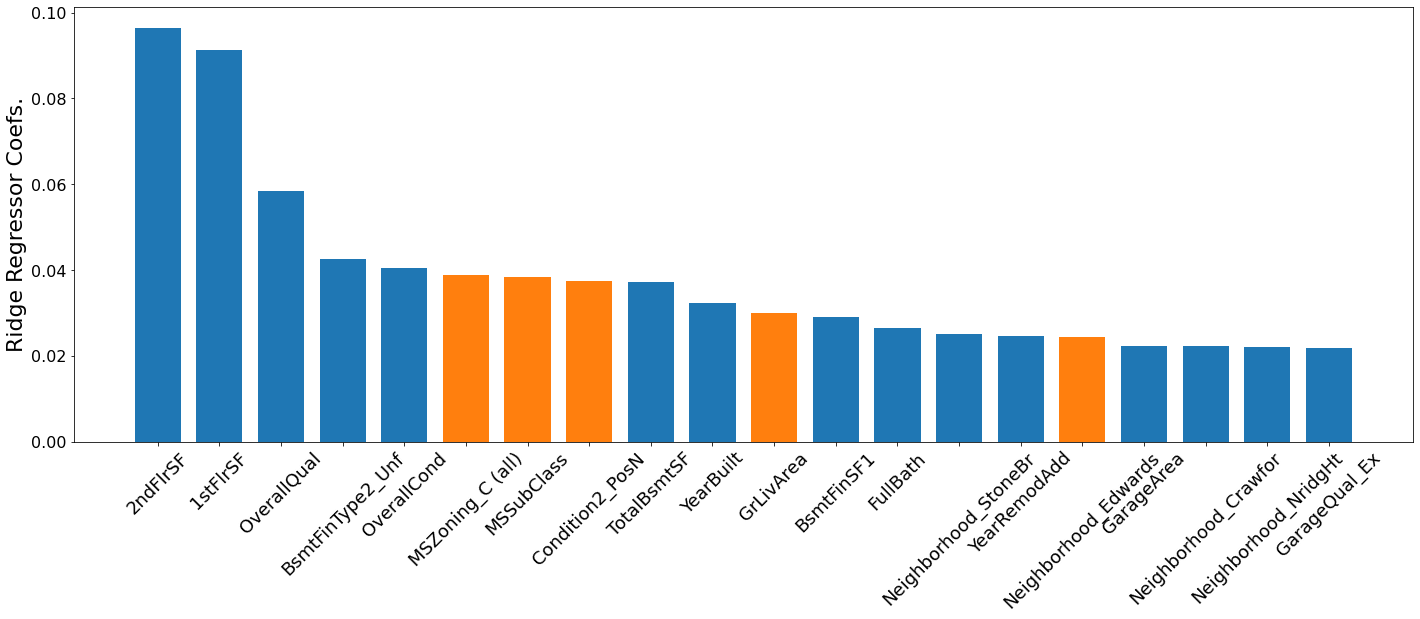

In [20]:
plt.figure(figsize=(24, 8))
coef_df = pd.DataFrame({'name': X.columns, 'coef': lin_model.coef_})
coef_df['magnitude'] = coef_df['coef'].abs()
coef_df['sign'] = coef_df['coef'] < 0
coef_df = coef_df.sort_values('magnitude', ascending=False)
n_coef = 20
coef_df = coef_df.iloc[:n_coef]
plt.bar(x=coef_df['name'], height=coef_df['magnitude'], 
        color=[sns.color_palette()[idx] for idx in coef_df['sign']],
        width=.75)
plt.ylabel('Ridge Regressor Coefs.', fontsize=22)
plt.tick_params(axis='y', labelsize=16, )
plt.tick_params(axis='x', labelsize=18, rotation=45)

plt.savefig('Ridge_feats_coefs.pdf', bbox_inches='tight')
plt.show()

## Gradient Boosting

In [21]:
grad_model = GradientBoostingRegressor(max_depth=3).fit(X_train, y_train)
y_pred_grad = grad_model.predict(X_test)
print(f'RMSLE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_grad))}')
print(f'RMALE: {np.sqrt(metrics.mean_absolute_error(y_test, y_pred_grad))}')

RMSLE: 0.12365298859235288
RMALE: 0.2997894832391996


### Model Explaination
Plot for each feature the relative feature importance

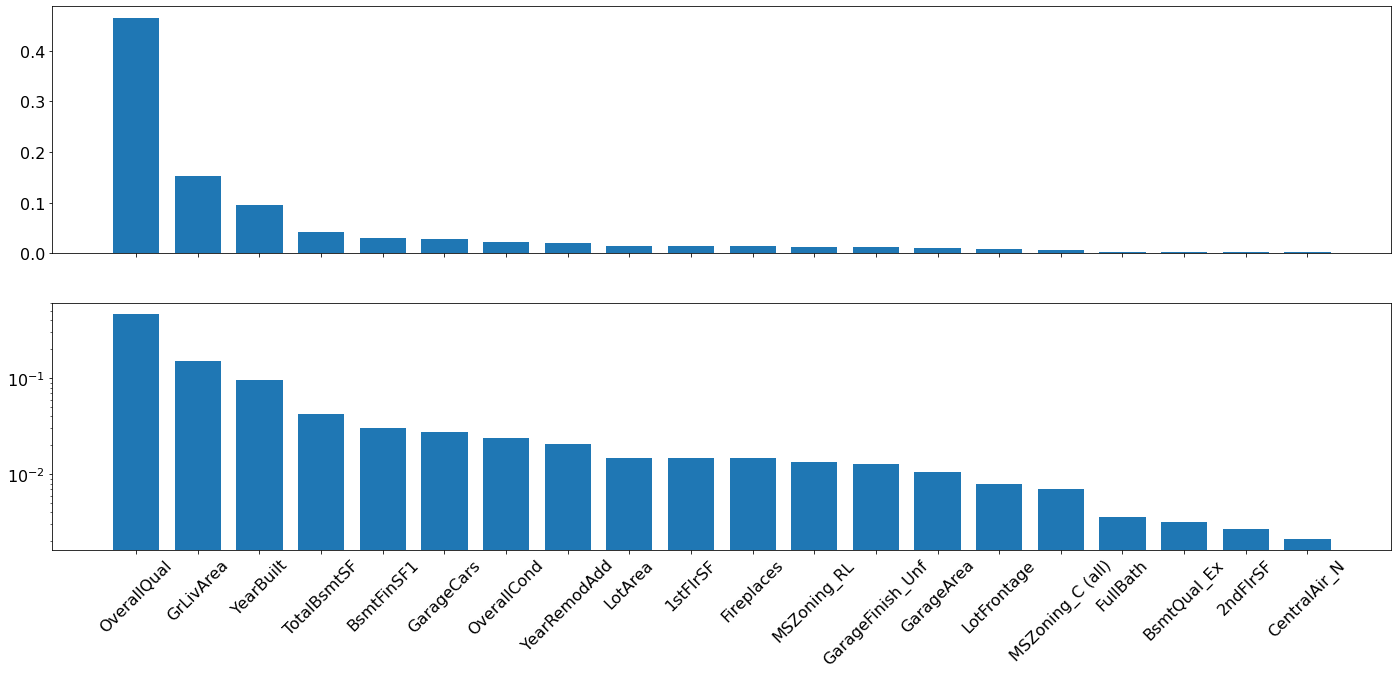

In [22]:
coef_df = pd.DataFrame({'name': X.columns, 'coef': grad_model.feature_importances_})
coef_df = coef_df.sort_values('coef', ascending=False)
n_coef = 20
coef_df = coef_df.iloc[:n_coef]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 10))
ax1.bar(x=coef_df['name'], height=coef_df['coef'], width=.75)
ax2.bar(x=coef_df['name'], height=coef_df['coef'], width=.75)
ax2.set_yscale('log')
ax1.tick_params(axis='y', labelsize=16,)
ax2.tick_params(axis='y', labelsize=16,)
ax2.tick_params(axis='x', labelsize=16, rotation=45)
for t in ax1.xaxis.get_major_ticks():
    t.label1.set_visible(False)

    
plt.savefig('GBoosting_feat_imprt.pdf', bbox_inches='tight')
plt.show()

## Showcase of other models results

In [24]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
print(f'RMSLE: {metrics.mean_squared_error(y_test, y_pred_knn) ** (1/2)}')
print(f'RMAPE: {metrics.mean_absolute_error(y_test, y_pred_knn) ** (1/2)}')

RMSLE: 0.1989605044668147
RMAPE: 0.3676876359371167


In [25]:
svr_model = SVR().fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
print(f'RMSLE: {metrics.mean_squared_error(y_test, y_pred_svr) ** (1/2)}')
print(f'RMAPE: {metrics.mean_absolute_error(y_test, y_pred_svr) ** (1/2)}')

RMSLE: 0.19181297413673198
RMAPE: 0.34247929362526724


In [23]:
forest_model = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
price_pred_forest = np.exp(y_pred_forest)
RMSLE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_forest))
print(f'RMSLE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_forest))}')
print(f'RMALE: {np.sqrt(metrics.mean_absolute_error(y_test, y_pred_forest))}')

RMSLE: 0.14233126304345525
RMALE: 0.31208976978640357


## Ablation Study

In [26]:
def evaluate_feature_ablation(feats_to_remove, X_train, y_train, X_test, y_test, n_times=5):
    return np.sqrt([metrics.mean_squared_error(
        y_test, 
        GradientBoostingRegressor().fit(X_train.drop(columns=feats_to_remove), 
                                                 y_train).predict(X_test.drop(columns=feats_to_remove))
    ) for i in range(n_times)])

0it [00:00, ?it/s]

[]

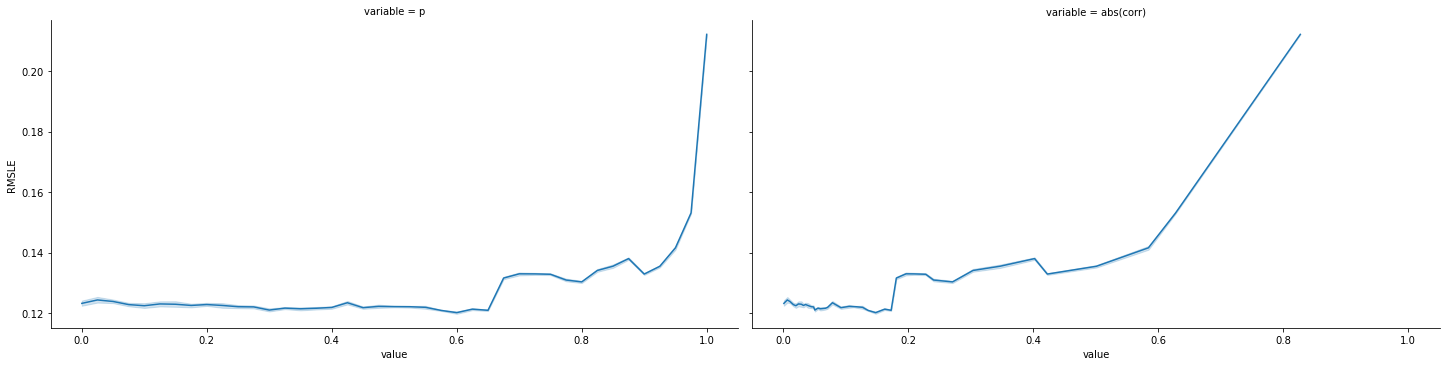

In [27]:
feats_corr = transf_df.copy()
feats_corr['SalePrice'] = np.log(feats_corr['SalePrice'])
feats_corr = feats_corr.corr(method='spearman')[['SalePrice']].drop('SalePrice')

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

df_rmsle = []

n_points = 41
for p, q in tqdm(zip(np.linspace(0, 1, n_points), np.quantile(feats_corr['SalePrice'].dropna().abs().values, q=np.linspace(0, 1, n_points)))):
    feats_to_drop = feats_corr[feats_corr['SalePrice'].abs() < q]
    df_rmsle.append(pd.DataFrame({'p': p, 'abs(corr)': q, 'RMSLE': evaluate_feature_ablation(feats_to_drop.index, X_train_df, y_train, 
                                                                                             X_test_df, y_test, n_times=10)}))

df_rmsle = pd.concat(df_rmsle, ignore_index=True)

sns.relplot(data=df_rmsle.melt('RMSLE'), x='value', y='RMSLE', col='variable', kind='line', aspect=2)
plt.savefig('ablation_study.pdf', bbox_inches='tight')
plt.plot()

In [28]:
res_ablation_study = df_rmsle.groupby('p').mean().reset_index()
for key, val in res_ablation_study.loc[res_ablation_study['RMSLE'].argmin()].round(3).items():
    print(f'{key}: {val}')

p: 0.6
abs(corr): 0.148
RMSLE: 0.12


In order to get the best possible model we drop all the features such that the Spearman correlation between each feature and $log(Price)$ is $-0.15 < \rho < 0.15$, doing so we are removing $\sim60\%$ of the features.

## Fit the Gradient Boosting removing Uncorrealted Features

In [29]:
clean_X_train = X_train[:, (feats_corr.abs() > 0.15)['SalePrice']]
clean_X_test = X_test[:, (feats_corr.abs() > 0.15)['SalePrice']]
best_model = GradientBoostingRegressor(max_depth=3).fit(clean_X_train, y_train)
y_pred_grad = best_model.predict(clean_X_test)
print(f'RMSLE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred_grad))}')
print(f'RMALE: {np.sqrt(metrics.mean_absolute_error(y_test, y_pred_grad))}')

RMSLE: 0.11929688161634908
RMALE: 0.2944510690291099


### Error Analysis and Confidence Interval

The 95.0% of the residuals, defined as log(True Price) - log(Predicted Price), are within the interval [-0.246, 0.218]


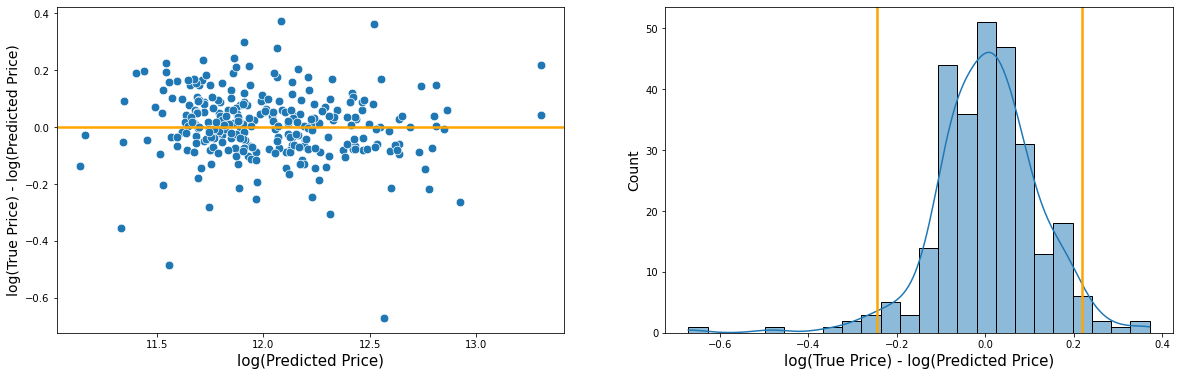

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
sns.scatterplot(x=y_pred_grad, y=y_test - y_pred_grad, ax=ax1, s=75)
ax1.set_ylabel('log(True Price) - log(Predicted Price)', fontsize=14)
ax1.set_xlabel('log(Predicted Price)', fontsize=15)

sns.histplot(x=y_test - y_pred_grad, kde=True, ax=ax2)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_xlabel('log(True Price) - log(Predicted Price)', fontsize=15)

alpha = 0.05
lower_bound, upper_bound = np.quantile((y_test - y_pred_grad).values, q=[alpha/2, 1 - alpha/2])

ax1.axhline(0, color='orange', lw=2.5)
ax2.axvline(lower_bound, color='orange', lw=2.5)
ax2.axvline(upper_bound, color='orange', lw=2.5)

print(f'The {round((1-alpha) * 100, 1)}% of the residuals, defined as log(True Price) - log(Predicted Price),'
      f' are within the interval [{round(lower_bound, 3)}, {round(upper_bound, 3)}]')
plt.show()


# 3) Deployment and Prediction Explaination
### Here we created a widget box to store our users' input

In [31]:
style = {'description_width': 'initial'}
GrLivArea = widgets.IntText(description = 'Ground Living Area', style=style)
TotalBsmtSF =  widgets.IntText(min=0, description = 'Total Basement Squared Feet', style=style)
FirstFlrSF = widgets.IntText(min=0, description = 'First Floor Squared Feet', style=style)
OpenPorchSF = widgets.IntText(min=0, description = 'Open Porch Squared Feet', style=style)
YearRemodAdd = widgets.BoundedIntText(min=1950,max=2020, description = 'Year of remodernization', style=style)
GarageArea = widgets.IntText(description = 'Garage Area', style=style)
GarageYrBlt = widgets.BoundedIntText(min=1950,max=2020, description = 'Year the garage was built', style=style)
YearBuilt = widgets.BoundedIntText(min=1950,max=2020, description = 'Year the house was built', style=style)
FullBath = widgets.Dropdown(options=['0','1', '2', '3'], description = 'How Many Baths?', style=style)
TotRmsAbvGrd = widgets.Dropdown(options=['0','1', '2', '3'], description = 'How Many Rooms Above Ground?', style=style)
Fireplaces = widgets.Dropdown(options=['0','1', '2', '3'], description = 'How Many Fireplaces?', style=style)
GarageCars = widgets.Dropdown(options=['0','1', '2', '3'], description = 'How Many Garage Cars', style=style)
OverallQual = widgets.IntSlider(min=0,max=10, description = 'Overall Quality of the House', style=style)
ExterQual_Gd = widgets.ToggleButtons(options=['True','False'], description = 'Do you want a good exterior quality?', style=style)
Foundation_PConc = widgets.ToggleButtons(options=['True','False'], description = 'Do you want Concrete foundations?', style=style)
HeatingQC_Ex = widgets.ToggleButtons(options=['True','False'], description = 'Do you want an Excelent Heating?', style=style)
widgets.VBox([GrLivArea, TotalBsmtSF, OpenPorchSF, YearRemodAdd,
              GarageArea, GarageYrBlt, YearBuilt, FullBath, 
              TotRmsAbvGrd, Fireplaces, GarageCars, OverallQual, 
              ExterQual_Gd,Foundation_PConc, HeatingQC_Ex])

RMSLE: 0.13905081784527545
RMALE: 0.3231947269249575
The 95.0% of the residuals are within the interval [-0.258, 0.274]


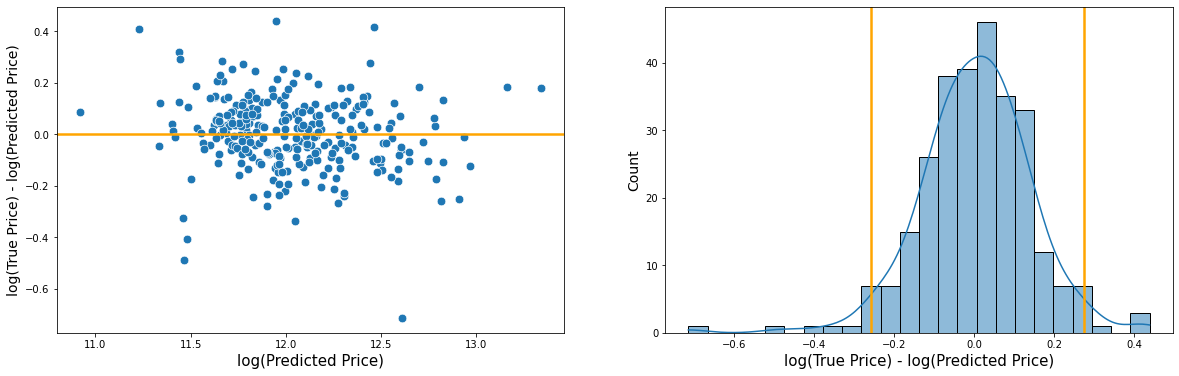

In [47]:
# Select
selected_feats_X = transf_df[feats_corr[feats_corr['SalePrice'] > .5].index]
selected_feats_y = np.log(transf_df['SalePrice'])
# Split
depl_X_train, depl_X_test, depl_y_train, depl_y_test = train_test_split(selected_feats_X, selected_feats_y, shuffle=False, train_size=.75)
# Normalize
depl_scaler = preprocessing.StandardScaler().fit(depl_X_train)
depl_X_train = depl_scaler.transform(depl_X_train)
depl_X_test = depl_scaler.transform(depl_X_test)
# Train and predict
deploy_model = GradientBoostingRegressor(max_depth=3).fit(depl_X_train, depl_y_train)
depl_y_pred = deploy_model.predict(depl_X_test)
print(f'RMSLE: {np.sqrt(metrics.mean_squared_error(depl_y_test, depl_y_pred))}')
print(f'RMALE: {np.sqrt(metrics.mean_absolute_error(depl_y_test, depl_y_pred))}')

# Error CI
alpha = 0.05
lower_bound, upper_bound = np.quantile((depl_y_test - depl_y_pred).values, q=[alpha/2, 1 - alpha/2])

# Plots:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# 1) Residual Plot 
sns.scatterplot(x=depl_y_pred, y=depl_y_test - depl_y_pred, ax=ax1, s=75)
ax1.set_ylabel('log(True Price) - log(Predicted Price)', fontsize=14)
ax1.axhline(0, color='orange', lw=2.5)
ax1.set_xlabel('log(Predicted Price)', fontsize=15)
# 2) Residual Hist Plot
sns.histplot(x=depl_y_test - depl_y_pred, kde=True, ax=ax2)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_xlabel('log(True Price) - log(Predicted Price)', fontsize=15)
ax2.axvline(lower_bound, color='orange', lw=2.5)
ax2.axvline(upper_bound, color='orange', lw=2.5)

# Print CI
print(f'The {round((1-alpha) * 100, 1)}% of the residuals are within the interval [{round(lower_bound, 3)}, {round(upper_bound, 3)}]')
plt.savefig('error_and_CI.pdf', bbox_inches='tight')
plt.show()

#### Price range creation and evaluation

In [44]:
row = [GrLivArea.value, FirstFlrSF.value, TotalBsmtSF.value, 
       OpenPorchSF.value, YearRemodAdd.value, GarageArea.value, 
       GarageYrBlt.value, YearBuilt.value, FullBath.value, 
       TotRmsAbvGrd.value, Fireplaces.value, GarageCars.value, 
       OverallQual.value, bool(ExterQual_Gd.value), bool(Foundation_PConc.value), 
       bool(HeatingQC_Ex.value)]
test_sample = pd.DataFrame(dict(zip(feats_corr[feats_corr['SalePrice'] > .5].index, row)), index=[1])
sample_log_pred = deploy_model.predict(depl_scaler.transform(test_sample))[0]

print(f'Predicted Price: {round(np.exp(sample_log_pred))}')
print(f'{round((1-alpha) * 100, 1)}% Price CI: {[round(np.exp(sample_log_pred+lower_bound)), round(np.exp(sample_log_pred+upper_bound))]}')

Predicted Price: 146118
95.0% Price CI: [112856, 188647]


In [74]:
pd.concat([test_sample.T.iloc[i*4:(i+1)*4].reset_index().rename(columns={'index': 'Feature', 1: 'Value'}) for i in range(4)], axis=1, ignore_index=False)

,Feature,Value,Feature,Value,Feature,Value,Feature,Value
0,TotalBsmtSF,1000,OpenPorchSF,2005,FullBath,3,OverallQual,8
1,GrLivArea,0,1stFlrSF,3000,TotRmsAbvGrd,2,ExterQual_Gd,True
2,GarageArea,1500,GarageYrBlt,2005,Fireplaces,1,Foundation_PConc,True
3,YearBuilt,500,YearRemodAdd,1990,GarageCars,1,HeatingQC_Ex,True


In [35]:
house_price = int(input("Insert the house price that you found: "))
if house_price >= np.exp(sample_log_pred+upper_bound):
    print('Too Expensive!')
elif house_price >= np.exp(sample_log_pred):
    print('Kind of Expensive')
elif house_price >= np.exp(sample_log_pred+lower_bound):
    print('Kind of Convenient')
else:
    print("It's a Deal!")

Insert the house price that you found: 200000
Too Expensive!


In [45]:
shap.initjs()
explainer = shap.Explainer(deploy_model)
shap_values = explainer(test_sample)
shap.plots.force(shap_values[0])

# 4) Kaggle Predictions
## Load and preprocess the test dataset

In [36]:
test_df = pd.read_csv("test.csv", index_col='Id').drop(columns=['Functional', 'LowQualFinSF'])
idx = test_df.index
encoded_test_df = pd.DataFrame()
for col in cat_col:
    one_hot_df = pd.get_dummies(test_df[col], prefix=col)
    encoded_test_df = pd.concat([encoded_test_df, one_hot_df], axis=1)
test_df = pd.concat([test_df[num_col + cat_num_col], encoded_test_df], axis=1)
test_df[list(set(transf_df.columns).difference(test_df.columns))] = 0
test_df = test_df[transf_df.columns].drop(columns='SalePrice')
test_df = pd.DataFrame(scaler.transform(test_df), columns=transf_df.columns[:-1]).fillna(0)
test_df

,TotalBsmtSF,ScreenPorch,2ndFlrSF,3SsnPorch,GrLivArea,GarageArea,EnclosedPorch,WoodDeckSF,LotFrontage,PoolArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.461490,1.864275,-0.797668,-0.118539,-1.239990,1.185190,-0.350079,0.363999,0.410175,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,-0.262111,-0.034524,-0.098058,-0.120386,0.496277,-0.348562
1,0.585621,-0.278325,-0.797668,-0.118539,-0.389879,-1.021919,-0.350079,2.458977,0.453120,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,-0.262111,-0.034524,-0.098058,-0.120386,0.496277,-0.348562
2,-0.353733,-0.278325,0.805137,-0.118539,0.199112,-0.124291,-0.350079,0.960198,0.152506,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,-0.262111,-0.034524,-0.098058,-0.120386,0.496277,-0.348562
3,-0.358418,-0.278325,0.752549,-0.118539,0.150029,-0.187653,-0.350079,2.185719,0.324285,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,-0.262111,-0.034524,-0.098058,-0.120386,0.496277,-0.348562
4,0.470837,2.292795,-0.797668,-0.118539,-0.486081,0.002433,-0.350079,-0.795277,-1.178787,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,-0.262111,-0.034524,-0.098058,-0.120386,0.496277,-0.348562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-1.248580,-0.278325,0.450737,-0.118539,-0.855182,-2.669331,-0.350079,-0.795277,-2.123575,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,-0.262111,-0.034524,-0.098058,-0.120386,0.496277,-0.348562
1455,-1.248580,-0.278325,0.450737,-0.118539,-0.855182,-1.159204,-0.350079,-0.795277,-2.123575,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,3.815174,-0.034524,-0.098058,-0.120386,-2.015004,-0.348562
1456,0.339656,-0.278325,-0.797668,-0.118539,-0.596026,0.372044,-0.350079,3.129701,3.845768,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,3.815174,-0.034524,-0.098058,-0.120386,-2.015004,-0.348562
1457,-0.391214,-0.278325,-0.797668,-0.118539,-1.094705,-2.669331,-0.350079,-0.132834,-0.362833,-0.04852,...,-0.059868,-0.344251,0.0,0.4279,-0.262111,-0.034524,-0.098058,-0.120386,0.496277,-0.348562


## Make predictions and save them on a file

In [37]:
test_pred = best_model.predict(test_df.values[:, (feats_corr.abs() > 0.15)['SalePrice']])
price_pred = np.exp(test_pred)
price_pred_df = pd.DataFrame({'Id': idx, 'SalePrice': price_pred})
price_pred_df.to_csv('my_sub.csv', index=False)
price_pred_df

,Id,SalePrice
0,1461,118604.432061
1,1462,151753.027444
2,1463,190273.351459
3,1464,190011.633956
4,1465,188772.933917
...,...,...
1454,2915,87837.760345
1455,2916,93242.239995
1456,2917,166097.158139
1457,2918,124467.537207
